In [55]:
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import numpy as np
import pandas as pd

import pickle

from scipy.signal import savgol_filter
from scipy.optimize import minimize
from scipy.interpolate import interp1d

from G4EPP import api
from G4EPP import EnergyDistributions as dists
from G4EPP import XrayAnalysis

Api = api()

X = XrayAnalysis();

Eabsc = api().get_energy_array()

E     = api().get_run_list()       # eV
PA    = api().get_PA_list()        # deg

ExpDist = dists().exponential()


import seaborn as sns
sns.set_theme(font_scale=1.5)

G = 716 # cm^2-sr , average BARREL geometric factor

ALT1 = 32
ALT2 = 33

# Define background model (see Berland, et al. 2023)

In [12]:

def bg_model_mm_v4(energylist, alt):
    """
    ;+  return a background x-ray model
    ;
    ; INPUT: energylist is a list of energies (keV)
    ;        alt is altitude in km (25<alt<40)
    ;
    ; OUTPUT: returns a list of counts/s/kev corresponding to energylist
    ;         returns -1 for input energy < 20keV
    ;
    ; METHOD: based on an empirical model derived from BARREL flights
    ;         model is ok between 20 and 8000 keV
    ;         background is primarily two power law components
    ;            these turn over at low energy
    ;            features at 26, 36, 312, 446, and 511 keV included
    ;         prevent underflows by avoiding exp(-huge number)
    ;
    ; CALLS: none
    ;
    ; EXAMPLE: result = brl_makebkgd([20,50,100,200],33.2)
    ;            calculates bkgd differential count rate at the
    ;            4 specified energies for a detector at 33.2 km alt.
    ;
    ; FUTURE WORK:
    ;
    ;COMMENT
    ; model ignores solar cycle changes of cosmic ray and associated background X-ray intensity
    ; the estimation for < 60keV is to some extent affected by detector temperature effect.
    ; REVISION HISTORY:
    ; works, tested mm/18 Dec 2012
    ; version 2, updated LZ/ May 28th, 2013 .
    ;- better constants values and latitude function than previous version
    ; version 4, updated LZ/ Mar 2015.
    ;- better constants values, more small features modelled
    ;- no longer uses mag latitude, since this effect was small
    ;- used data from second campaign to improve model
    # rewritten in Python, converted GB/ Jul 2023
    """
    if np.min(energylist) < 5: 
        return -1
    
    if alt < 25 or alt > 40:
        return -1
    
    altfactor = np.exp(-alt/8.5)
    
    S = len(energylist)

    c1 = 4.660e7*(altfactor + 0.03091)
    c2 = 340.8*(altfactor + 0.05344)
    c3 = 3.789*(altfactor + 0.03685)
    c4 = 565.5 - 8.648*alt
    c5 = 15.95 - 0.1489*alt

    powerlaw1 = c1*(energylist)**(-2.75)
    powerlaw2 = c2*(energylist)**(-0.92)

    turnover1 = np.zeros([S,])+1.
    good = np.where(energylist < 450)[0]
    if good.size > 0:
        turnover1[good] += c4*np.exp(-energylist[good]/9.39)

    turnover2 = np.zeros([S,])+1.
    good = np.where(energylist < 2000)[0]
    if good.size > 0:
        turnover2[good] += c5*np.exp(-energylist[good]/45.5)

    area26=np.zeros([S,])
    good = np.where(energylist < 60)[0]
    if good.size > 0:
        area26[good] = -0.32*np.exp(-((energylist[good]-25.6)/3.55)**2/2)

    area36=np.zeros([S,])
    good = np.where(energylist < 85)[0]
    if good.size > 0:
        area36[good] = 0.55*np.exp(-((energylist[good]-35.5)/5.1)**2/2)

    area312=np.zeros([S,])
    good = np.where((100 < energylist) & (energylist < 500))[0]
    if good.size > 0:
        area312[good] = 0.13*np.exp(-((energylist[good]-312)/20.)**2/2)

    area446=np.zeros([S,])
    good = np.where(energylist < 1000)[0]
    if good.size > 0:
        area446[good] = 0.18*np.exp(-((energylist[good]-445.47)/60.)**2/2)

    area511=np.zeros([S,])
    good = np.where((300 < energylist) & (energylist < 700))[0]
    if good.size > 0:
        area511[good] = np.exp(-((energylist[good]-511)/20.)**2/2)

    peaks = c3*(area511 + area446 + area312) + area36 + area26

    return (powerlaw1+powerlaw2)/(turnover1*turnover2) + peaks
    

# Plot BARREL X-ray data and background model

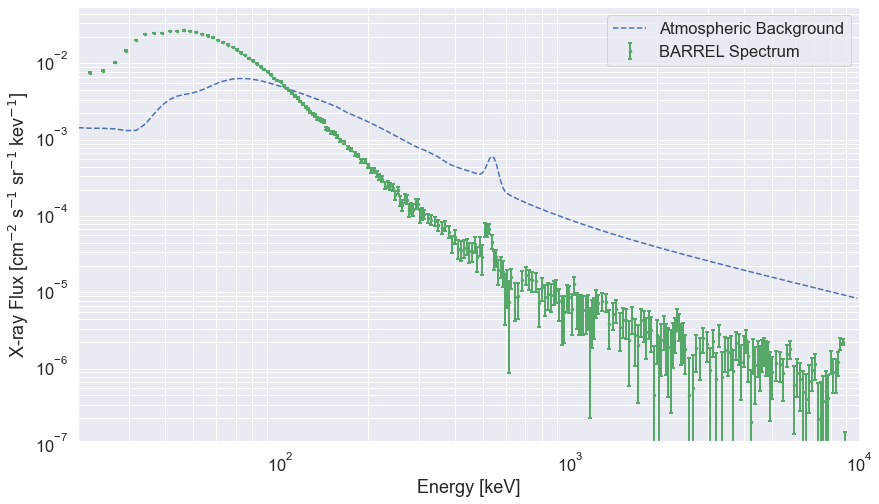

In [36]:
spec1   = pd.read_csv('data/BARREL/barrel_xray_spectra_1.txt', names=['E', 'cts', 'cts_err'], sep=' ')

spec1.cts     /= G
spec1.cts_err /= G


Eb = bg_model_mm_v4(spec1.E[3:], ALT2)


plt.figure(figsize=(14,8)); plt.grid(which='both')

plt.errorbar(spec1.E[3:], spec1.cts[3:], yerr=spec1.cts_err[3:], markersize=3,
             marker='.', ls=' ', c='g', label='BARREL Spectrum',
             capsize=2, elinewidth=2, markeredgewidth=2)

plt.loglog(spec1.E[3:], Eb/G, 'b--', label='Atmospheric Background')

plt.xlim(2e1, 1e4);
plt.ylim(1e-7, 0.5e-1)

plt.xlabel('Energy [keV]')
plt.ylabel('X-ray Flux [cm$^{-2}$ s$^{-1}$ sr$^{-1}$ kev$^{-1}$]');
plt.legend();

# Define cost functions

In [32]:
def chi2(E, O, weights):
    return np.nansum( weights * ( (E - O)**2 / E ) )

def LLS(E, O, weights):
    return np.nansum( weights * ( np.log( E / O )**2 ) )

# Plot example X-ray spectrum from E$_0$ = 100 keV electron input

/home/gdberla/anaconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in true_divide
  
/home/gdberla/anaconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: divide by zero encountered in true_divide


E0 = 100 keV, Chi2 = inf


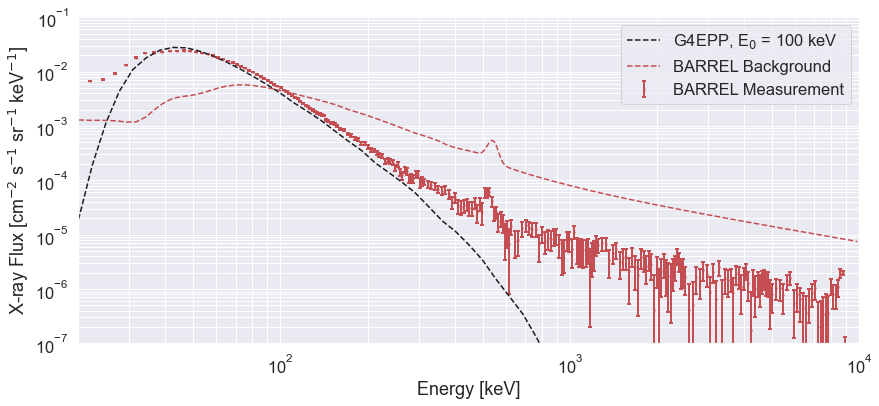

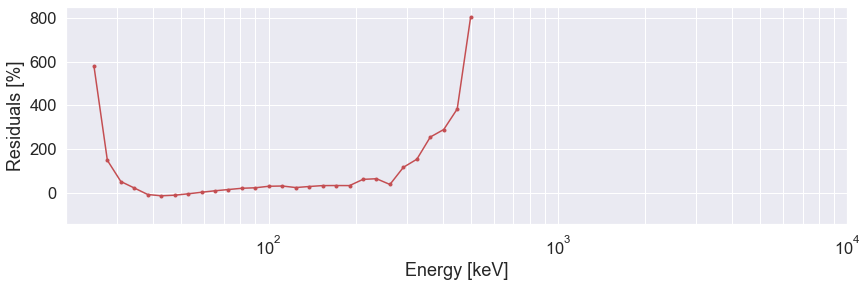

In [71]:

plt.figure(figsize=(14,6)); plt.grid(True, which='both')

PAD = np.sin(np.deg2rad(PA)) # sine PAD

plt.errorbar(spec1.E[3:], spec1.cts[3:], yerr=spec1.cts_err[3:], c='r', marker='.', ls=' ', markersize=1,
             label='BARREL Measurement', capsize=2, elinewidth=2, markeredgewidth=2);



for E0 in [100*1e3]:
    spectrum = X.getSpectrumAtAltitude(ExpDist(E, E0), PAD, 4e4, [ALT1, ALT2])

    plt.plot(Eabsc, spectrum, 'k--', label='G4EPP, E$_0$ = %.0f keV' % (E0*1e-3))
        
    #spectrum_bg = spectrum + np.interp(Eabsc[:], Ebar.values[:,0], Eb/G)
    
    #plt.step(Eabsc, spectrum_bg, label='G4EPP + background', where='mid', linewidth=3)
    
    print("E0 = %.0f keV, Chi2 = %.3e" % 
          (E0/1e3, chi2(spectrum, 
                        np.interp(Eabsc, spec1.E[3:], spec1.cts[3:]), 
                        np.ones(spectrum.shape))))
    
    
    
    
        
plt.yscale('log')
plt.xscale('log')
plt.xlabel("Energy [keV]")
plt.ylabel("X-ray Flux [cm$^{-2}$ s$^{-1}$ sr$^{-1}$ keV$^{-1}$]")
plt.ylim(1e-7, 1e-1);
plt.xlim(2e1, 1e4);

plt.loglog(spec1.E[3:], Eb/G, 'r--', label='BARREL Background');
plt.legend();


res = 100*(np.interp(Eabsc, spec1.E[2:], spec1.cts[2:]) - spectrum)/spectrum

res[np.abs(res) > 1e3] = np.nan

plt.figure(figsize=(14,4)); plt.grid(True, which='both')
plt.plot(Eabsc, res, c='r', marker='.', ls='-');
plt.xscale('log')
plt.xlim(2e1, 1e4);
plt.ylabel('Residuals [%]');
plt.xlabel('Energy [keV]');

# Define fitting energy range and weights for cost function

In [ ]:
LOW  = 50
HIGH = 400

remappedCtErr = np.interp(Eabsc, spec1.E[2:], spec1.cts_err[2:])

weights  = ( remappedCtErr[(Eabsc > LOW) & (Eabsc < HIGH)] )**-1
weights /= np.sum(weights)

# Search the input space for the best fitting input spectrum

exp: chi2 = 1.114e-05
kappa: chi2 = 8.196e-05
12915496.650148828 2.033333333333333


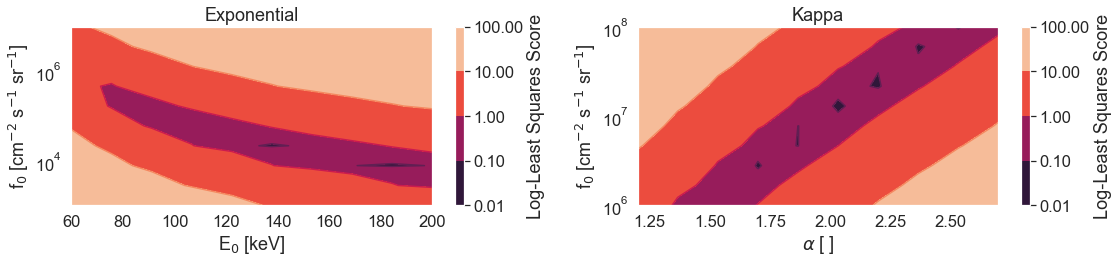

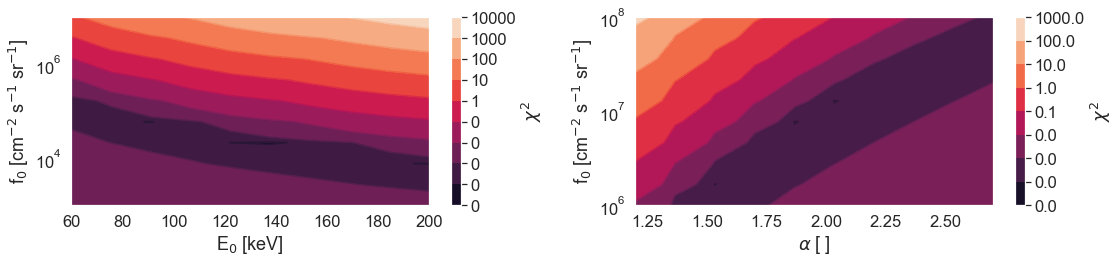

In [59]:

N = 10
M = 10
E0s = np.linspace(60, 200, N)*1e3
fluxes = np.logspace(3, 7, M)

chis = np.zeros([N,M])
chis2 = np.zeros([N,M])
for ind1, flux in enumerate(fluxes):
    for ind, E0 in enumerate(E0s):
        
        spectrum = X.getSpectrumAtAltitude(ExpDist(E, E0), PAD, flux, [ALT1, ALT2])

        tmp = np.interp(Eabsc, spec1.E[2:], spec1.cts[2:])
                
        chis[ind, ind1]  = LLS(tmp[(Eabsc > LOW) & (Eabsc < HIGH)], 
                               spectrum[(Eabsc > LOW) & (Eabsc < HIGH)],
                               weights)
        
        chis2[ind, ind1] = chi2(tmp[(Eabsc > LOW) & (Eabsc < HIGH)], 
                                spectrum[(Eabsc > LOW) & (Eabsc < HIGH)],
                                weights)
        

print("exp: chi2 = %.3e" % np.min(chis2))

oflux_e  = fluxes[np.where(chis == np.min(chis))[1][0]]
oE0      = E0s[np.where(chis == np.min(chis))[0][0]]

        
Xs,Ys = np.meshgrid(E0s*1e-3, fluxes)    

plt.figure(1, figsize=(16,4)); plt.subplot(1,2,1)
plt.contourf(Xs, Ys, chis.T, 6, norm=LogNorm())
plt.colorbar(label='Log-Least Squares Score');
plt.contour(Xs, Ys, chis.T, 6, norm=LogNorm())

plt.yscale('log')
plt.xlabel('E$_0$ [keV]')
plt.ylabel('f$_0$ [cm$^{-2}$ s$^{-1}$ sr$^{-1}$]');
plt.title('Exponential')

plt.figure(2, figsize=(16,4)); plt.subplot(1,2,1)
plt.contourf(Xs, Ys, chis2.T, 5, norm=LogNorm())
plt.colorbar(label='$\chi^2$');
plt.contour(Xs, Ys, chis2.T, 5, norm=LogNorm())

plt.yscale('log')
plt.xlabel('E$_0$ [keV]')
plt.ylabel('f$_0$ [cm$^{-2}$ s$^{-1}$ sr$^{-1}$]');


N = 10
M = 10
a_s = np.linspace(1.2, 2.7, N)
fluxes = np.logspace(6, 8, M)



def kappa3D(x, a):
    return a * (a + x**a)**(-(a+1)/a)

def kappa4D(x, h, k):
    return (1 - k*x)**(1/k-1) * (1 - h*(1 - k*x)**(1/k))**(1/h-1)
    

chis = np.zeros([N,M])
chis2 = np.zeros([N,M])
for ind1, flux in enumerate(fluxes):
    for ind, a in enumerate(a_s):
        
        spectrum = X.getSpectrumAtAltitude(kappa3D(E, a), PAD, flux, [ALT1, ALT2])


        tmp = np.interp(Eabsc, spec1.E[2:], spec1.cts[2:])        
                
        chis[ind, ind1]  = LLS(tmp[(Eabsc > LOW) & (Eabsc < HIGH)], 
                               spectrum[(Eabsc > LOW) & (Eabsc < HIGH)],
                               weights)
        
        chis2[ind, ind1] = chi2(tmp[(Eabsc > LOW) & (Eabsc < HIGH)], 
                                spectrum[(Eabsc > LOW) & (Eabsc < HIGH)],
                                weights)
        
        


print("kappa: chi2 = %.3e" % np.min(chis2))

oflux_k  = fluxes[np.where(chis == np.min(chis))[1][0]]
ok       = a_s[np.where(chis == np.min(chis))[0][0]]

print(oflux_k, ok)
        
Xs,Ys = np.meshgrid(a_s, fluxes)    

plt.figure(1); plt.subplot(1,2,2)
plt.contourf(Xs, Ys, chis.T, 6, norm=LogNorm())
plt.colorbar(label='Log-Least Squares Score');

plt.contour(Xs, Ys, chis.T, 6, norm=LogNorm())

plt.yscale('log')
plt.xlabel('$\\alpha$ [ ]')
plt.ylabel('f$_0$ [cm$^{-2}$ s$^{-1}$ sr$^{-1}$]');
plt.title('Kappa')

plt.tight_layout()


plt.figure(2); plt.subplot(1,2,2)
plt.contourf(Xs, Ys, chis2.T, 5, norm=LogNorm())
plt.colorbar(label='$\chi^2$');
plt.contour(Xs, Ys, chis2.T, 5, norm=LogNorm())

plt.yscale('log')
plt.xlabel('$\\alpha$ [ ]')
plt.ylabel('f$_0$ [cm$^{-2}$ s$^{-1}$ sr$^{-1}$]');

plt.tight_layout()



# Plot the best fits from the grid search

/home/gdberla/anaconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:50: RuntimeWarning: divide by zero encountered in true_divide
/home/gdberla/anaconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: divide by zero encountered in true_divide


Exp: Flux = 2.15e+04, E0    = 137.8 keV, chi2 = 0.000e+00
Kap: Flux = 1.29e+07, a     = 2.03    , chi2 = 0.000e+00


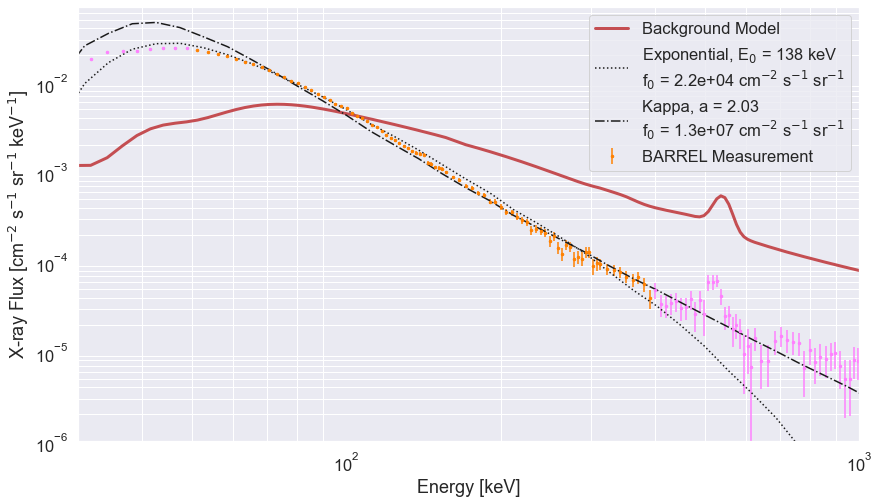

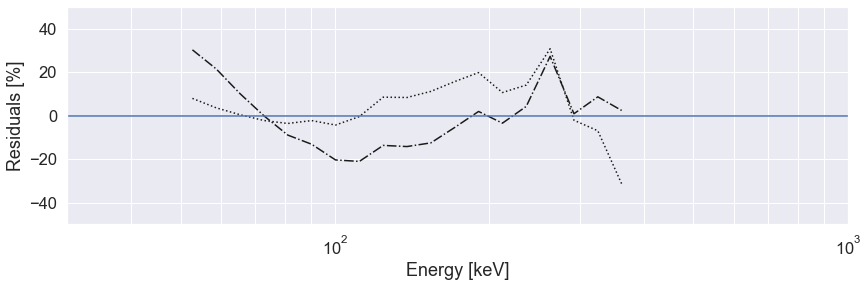

In [70]:
plt.figure(figsize=(14,8)); plt.grid(which='both')


plt.errorbar(spec1.E[2:][(spec1.E > LOW) & (spec1.E < HIGH)], 
             spec1.cts[2:][(spec1.E > LOW) & (spec1.E < HIGH)], 
             yerr=spec1.cts_err[2:][(spec1.E > LOW) & (spec1.E < HIGH)],
             c=[1, 0.5, 0], 
             marker='.', ls=' ', markersize=5,
             label='BARREL Measurement');

plt.errorbar(spec1.E[2:][(spec1.E < LOW) | (spec1.E > HIGH)], 
             spec1.cts[2:][(spec1.E < LOW) | (spec1.E > HIGH)], 
             yerr=spec1.cts_err[2:][(spec1.E < LOW) | (spec1.E > HIGH)],
             c=[1, 0.5, 1], 
             marker='.', ls=' ', markersize=5,
             label=None);

plt.loglog(spec1.E[3:], Eb/G, 'r', label='Background Model', linewidth=3);


spectrum2 = X.getSpectrumAtAltitude(ExpDist(E, oE0), PAD, oflux_e, [ALT1, ALT2])
spectrum3 = X.getSpectrumAtAltitude(kappa3D(E, ok), PAD, oflux_k, [ALT1, ALT2])


plt.plot(Eabsc, spectrum2, 'k', ls='dotted', 
         label='Exponential, E$_0$ = %.0f keV\nf$_0$ = %.1e cm$^{-2}$ s$^{-1}$ sr$^{-1}$' 
         % (1e-3*oE0, oflux_e))
plt.plot(Eabsc, spectrum3, 'k', ls='dashdot', 
         label='Kappa, a = %.2f\nf$_0$ = %.1e cm$^{-2}$ s$^{-1}$ sr$^{-1}$' 
         % (ok, oflux_k))


plt.xscale('log')
plt.yscale('log')

plt.xlabel("Energy [keV]")
plt.ylabel("X-ray Flux [cm$^{-2}$ s$^{-1}$ sr$^{-1}$ keV$^{-1}$]")

plt.ylim(1e-6, 0.7e-1);
plt.xlim(3e1, 0.1e4);
    
plt.legend()


tmp = np.interp(Eabsc, spec1.E[2:], spec1.cts[2:])

plt.figure(figsize=(14,4)); plt.grid(True, which='both')


e2 = 100*(spectrum2 - tmp)/spectrum2
e2[np.abs(e2) > 1e8] = np.nan

e3 = 100*(spectrum3 - tmp)/spectrum3
e3[np.abs(e3) > 1e8] = np.nan

plt.semilogx(Eabsc[(Eabsc > LOW) & (Eabsc < HIGH)], e2[(Eabsc > LOW) & (Eabsc < HIGH)], c='k', ls='dotted')
plt.semilogx(Eabsc[(Eabsc > LOW) & (Eabsc < HIGH)], e3[(Eabsc > LOW) & (Eabsc < HIGH)], c='k', ls='dashdot')

plt.hlines(0, 2e1, 1e4, linestyle='-')

plt.xlim(3e1, 0.1e4);
plt.ylim(-50, 50)
plt.ylabel('Residuals [%]');
plt.xlabel('Energy [keV]')


print("Exp: Flux = %.2e, E0    = %.1f keV, chi2 = %.3e" % (oflux_e, oE0*1e-3, np.min(chis2)))
print("Kap: Flux = %.2e, a     = %.2f    , chi2 = %.3e" % (oflux_k, ok, np.min(chis2)))